In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [2]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 3.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from hmmlearn.hmm import GaussianHMM

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error

In [4]:
%cd /content/drive/MyDrive/IS403/Project/Data

/content/drive/.shortcut-targets-by-id/1H00NdDTisvXwJcMmLshBS2Qn7PUvkU8H/IS403/Project/Data


# Function

In [5]:
def augment_features(dataframe):
    fracocp = (dataframe['Close']-dataframe['Open'])/dataframe['Open']
    frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    new_dataframe = pd.DataFrame({'delOpenClose': fracocp,
                                 'delHighOpen': frachp,
                                 'delLowOpen': fraclp})
    new_dataframe.set_index(dataframe.index)

    return new_dataframe

In [6]:
def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenClose'], dataframe['delHighOpen'], dataframe['delLowOpen']))

In [7]:
def possibleoutcomes(data):
  data_augmented = augment_features(data)
  fracocp = data_augmented['delOpenClose']
  frachp = data_augmented['delHighOpen']
  fraclp = data_augmented['delLowOpen']

  sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), 50)
  sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), 10)
  sample_space_frachp = np.linspace(frachp.min(), frachp.max(), 10)

  possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))

  return possible_outcomes

In [8]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [9]:
def train_test_valid(data):
  test_size  = 0.3
  valid_size = 0.1

  test_split_idx  = int(data.shape[0] * (1-test_size))
  valid_split_idx = int(data.shape[0] * (1-(valid_size+test_size)))

  train_data, test_data, valid_data = data[:valid_split_idx], data[valid_split_idx+1:test_split_idx], data[test_split_idx+1:]

  return train_data, test_data, valid_data

# AMAZON

## Data

In [10]:
df_amz = pd.read_csv("AMZN.csv")
df_amz

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,58.602501,58.982498,57.599998,58.117500,58.117500,82142000
1,2017-12-04,58.692501,58.759998,56.400002,56.697498,56.697498,118638000
2,2017-12-05,56.412998,57.963501,56.237000,57.078499,57.078499,81596000
3,2017-12-06,56.899502,57.794498,56.804001,57.617500,57.617500,57066000
4,2017-12-07,57.829498,58.159500,57.549999,57.989498,57.989498,50232000
...,...,...,...,...,...,...,...
1384,2023-06-05,123.360001,125.800003,123.029999,125.300003,125.300003,47950100
1385,2023-06-06,125.070000,127.400002,125.000000,126.610001,126.610001,45695200
1386,2023-06-07,127.010002,127.370003,120.629997,121.230003,121.230003,95663300
1387,2023-06-08,123.010002,125.629997,122.260002,124.250000,124.250000,62159300


## Preprocessing

### Check null and na value

In [11]:
df_amz.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [12]:
df_amz.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [13]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Close column data type: ", type(df_amz['Close'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Adj Close column data type: ", type(df_amz['Adj Close'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [14]:
df_amz['Date'] = pd.to_datetime(df_amz.Date)

## EDA

### Get the duration of dataset

In [15]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])
print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

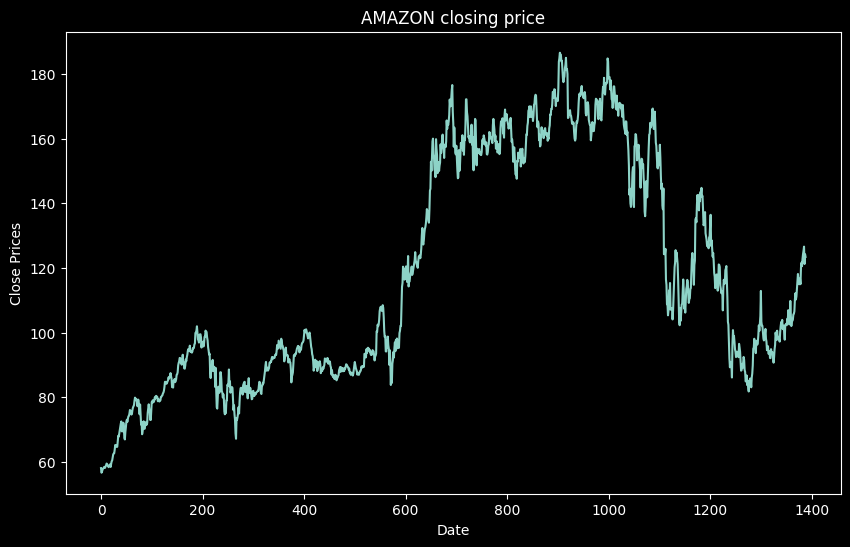

In [16]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_amz['Close'])
plt.title('AMAZON closing price')
plt.show()

## Train, test, valid

In [17]:
train_data, test_data, valid_data = train_test_valid(df_amz)

In [18]:
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)

feature_val_data = augment_features(valid_data)
features_val = extract_features(feature_val_data)

feature_test_data = augment_features(test_data)
features_test = extract_features(feature_test_data)

## Build & Train model

In [19]:
model = GaussianHMM()

### Choose n_component

In [20]:
n_components_values = [4, 6, 8, 10, 12, 14]
num_latent_days = 50
num_days_to_predict = 100

In [21]:
possible_outcomes_test = possibleoutcomes(test_data)

In [22]:
mae_num_components = []
for num_component in n_components_values:
    model = GaussianHMM(n_components=num_component)
    model.fit(features_train)
    predicted_close_prices = []
    for i in tqdm(range(num_days_to_predict)):
        # Calculate start and end indices
        previous_data_start_index = max(0, i - num_latent_days)
        previous_data_end_index = max(0, i)
        # Acquire test data features for these days
        previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

        outcome_scores = []
        for outcome in possible_outcomes_test:
            # Append each outcome one by one with replacement to see which sequence generates the highest score
            total_data = np.row_stack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))

        # Take the most probable outcome as the one with the highest score
        most_probable_outcome = possible_outcomes_test[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    mae_num_components.append((abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)).mean())

100%|██████████| 100/100 [04:55<00:00,  2.96s/it]


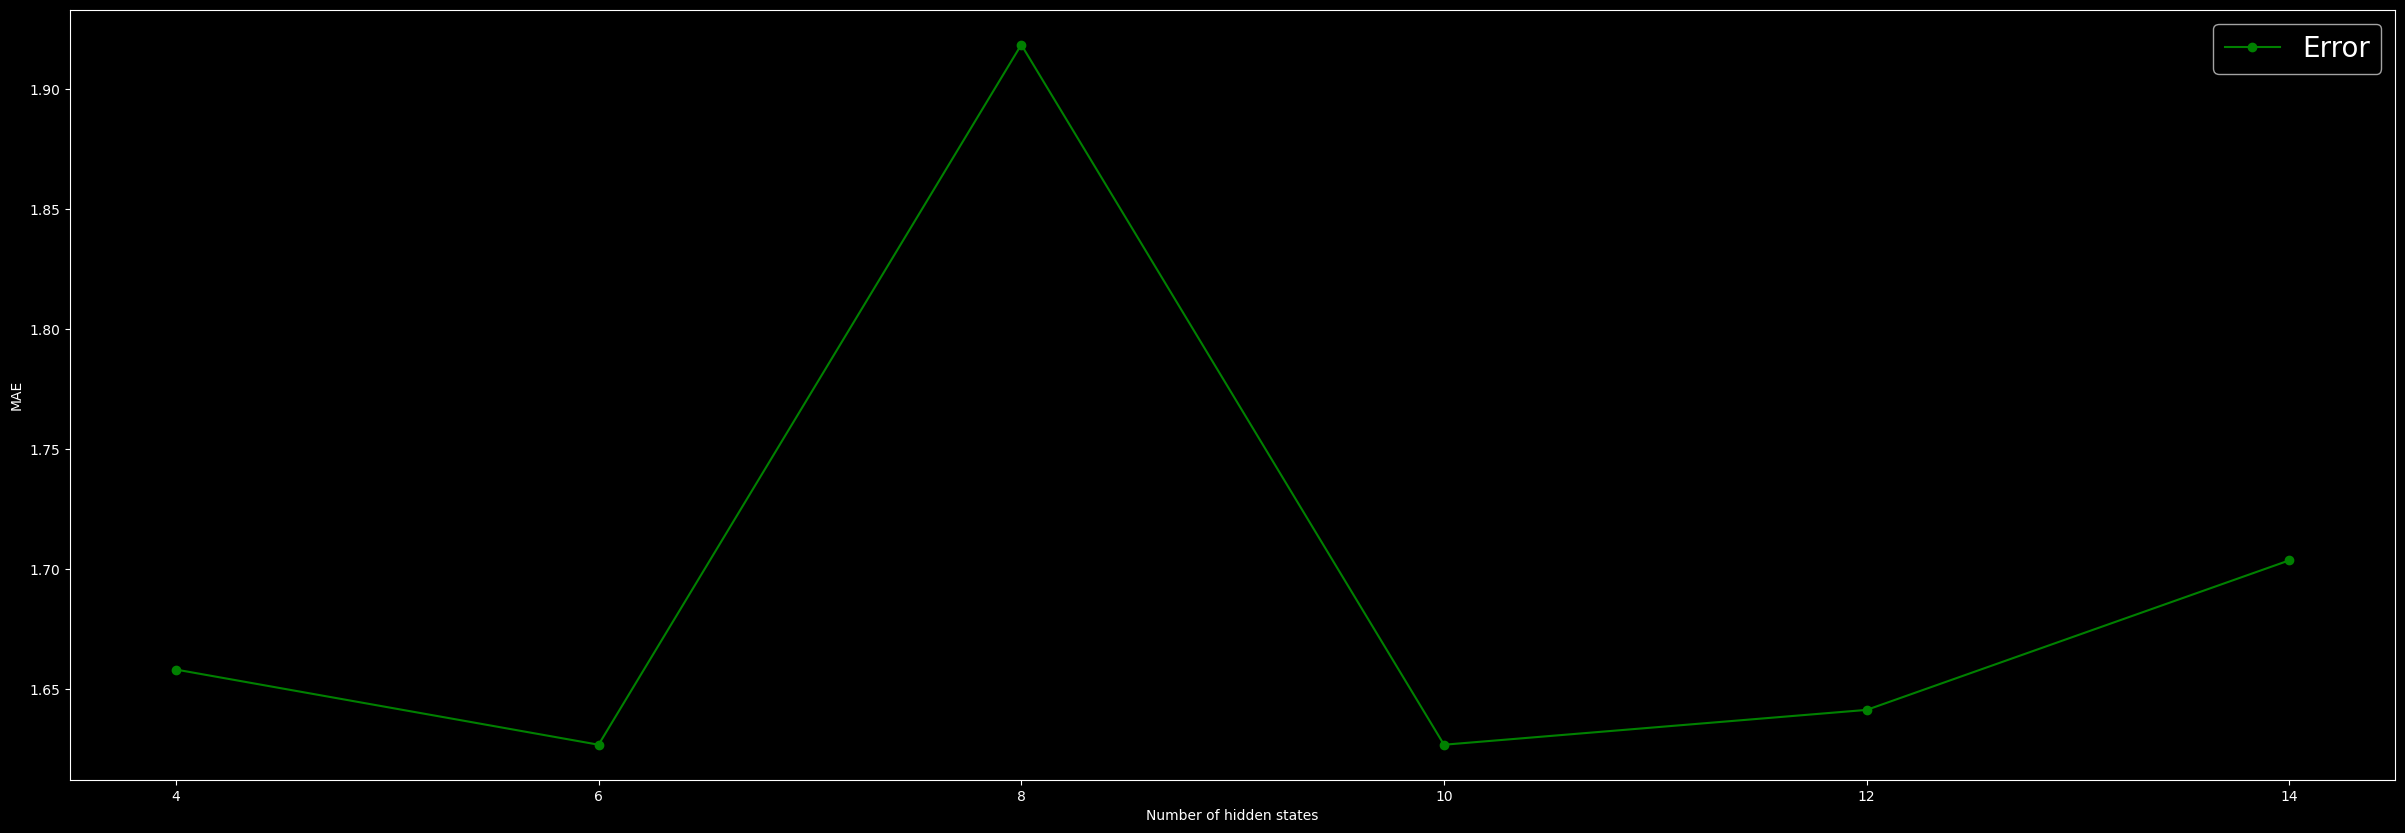

In [23]:
plt.figure(figsize=(30,10))

plt.plot(n_components_values, mae_num_components, 'go-', label="Error")
plt.xlabel("Number of hidden states")
plt.ylabel("MAE")
plt.legend(prop={'size': 20})
plt.show()

### Train

In [24]:
model = GaussianHMM(n_components=6).fit(features_train)

## Eval

In [25]:
predict_test = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

    outcome_scores = []
    for outcome in possible_outcomes_test:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))

    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes_test[np.argmax(outcome_scores)]
    predict_test.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 100/100 [03:50<00:00,  2.30s/it]


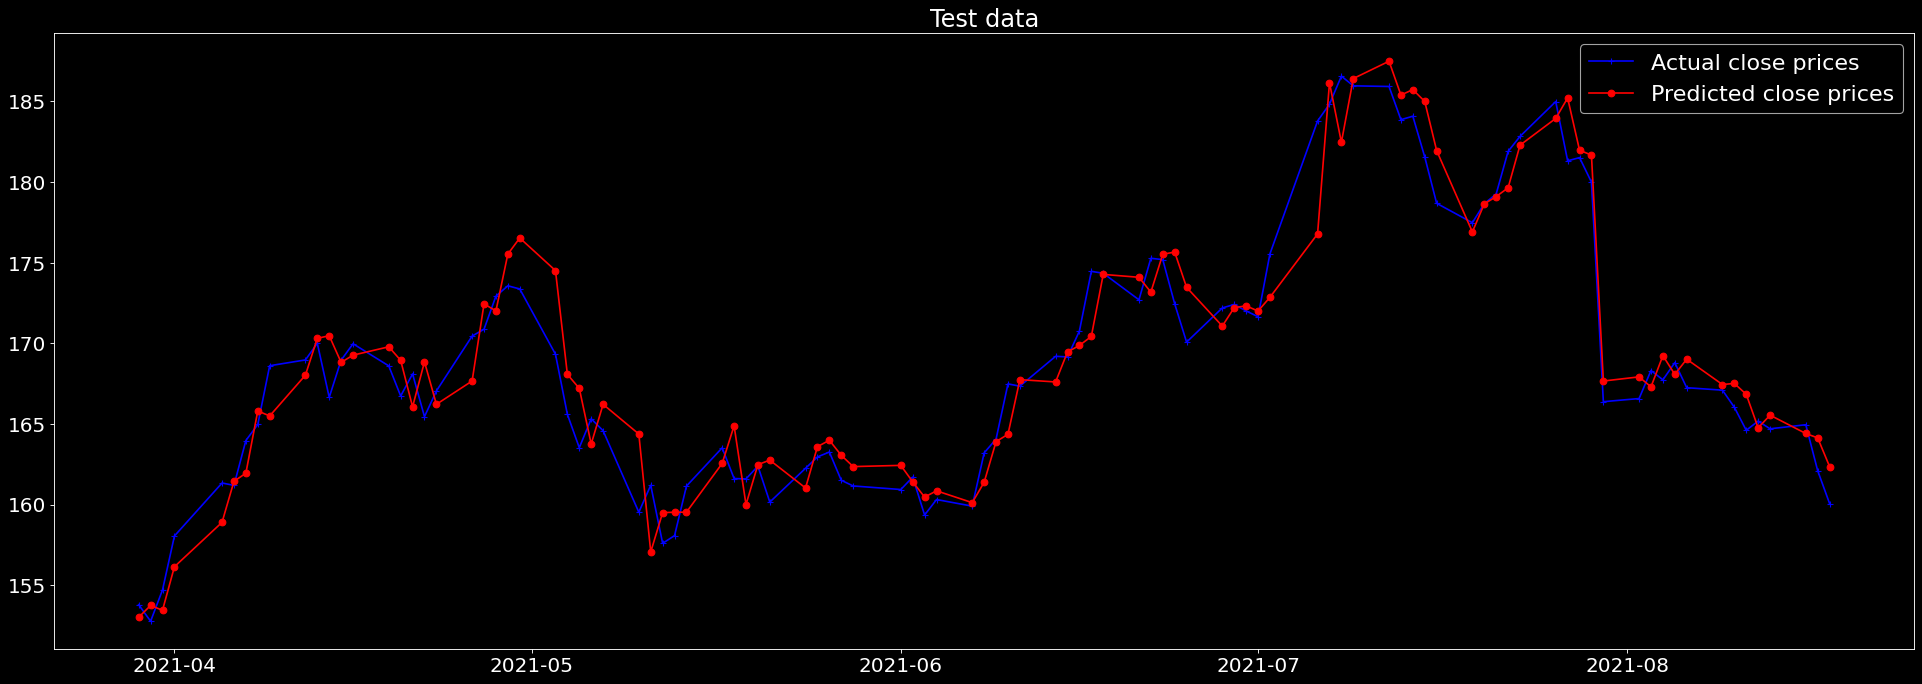

In [26]:
plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(test_data['Date'][0:num_days_to_predict])
plt.plot(x_axis, test_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predict_test, 'ro-', label="Predicted close prices")
plt.title('Test data')
plt.legend(prop={'size': 20})
plt.show()

In [27]:
possible_outcomes_val = possibleoutcomes(valid_data)

predict_val = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(valid_data.iloc[previous_data_start_index:previous_data_end_index]))

    outcome_scores = []
    for outcome in possible_outcomes_val:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))

    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes_val[np.argmax(outcome_scores)]
    predict_val.append(valid_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 100/100 [03:53<00:00,  2.34s/it]


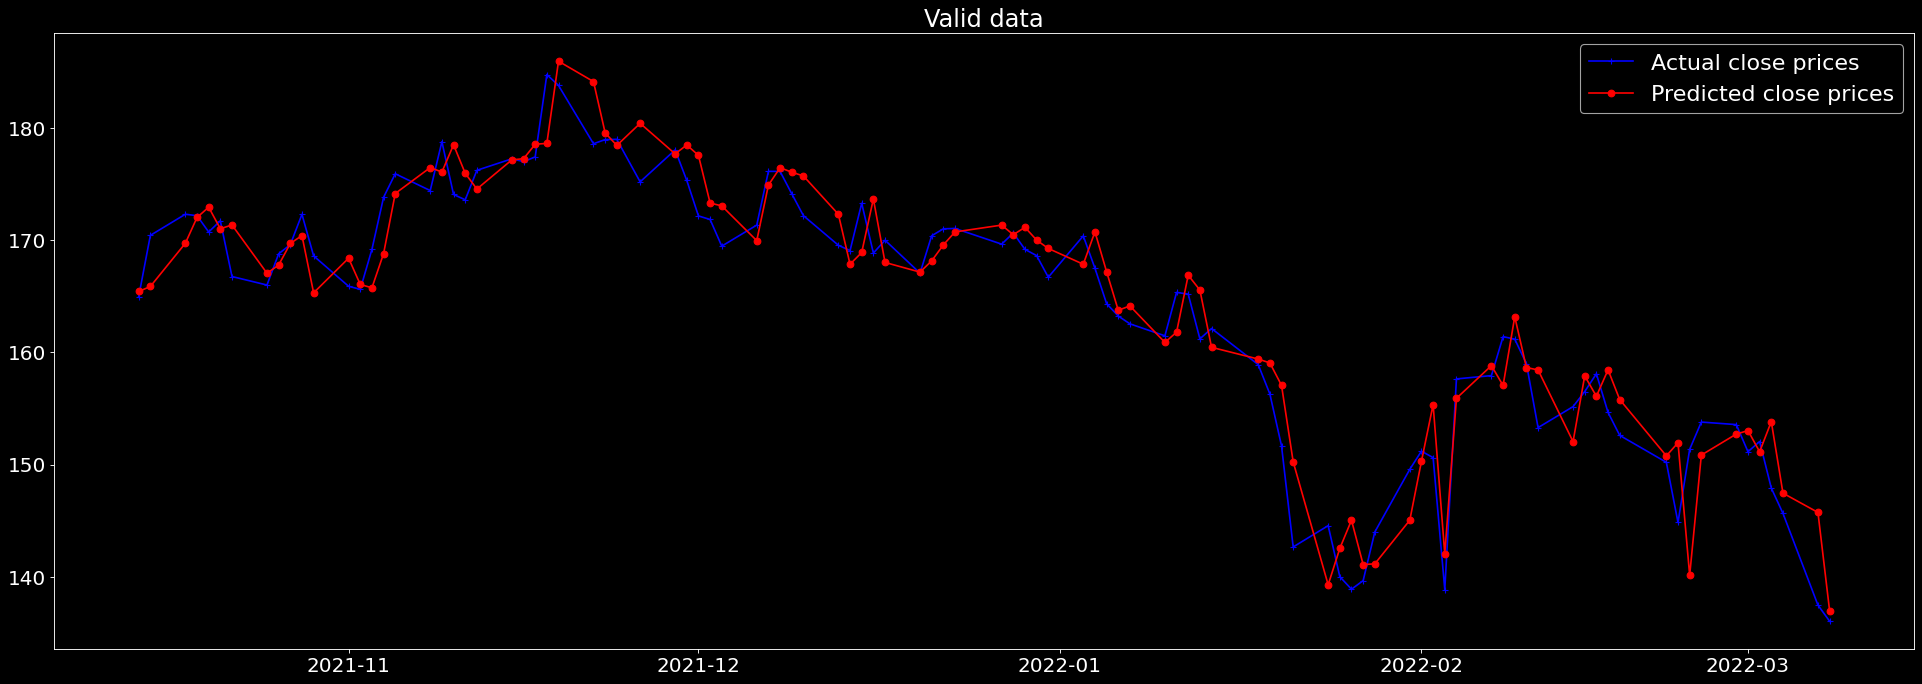

In [28]:
plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(valid_data['Date'][0:num_days_to_predict])
plt.plot(x_axis, valid_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predict_val, 'ro-', label="Predicted close prices")
plt.title('Valid data')
plt.legend(prop={'size': 20})
plt.show()

In [29]:
eval(test_data.iloc[0:num_days_to_predict]['Close'],predict_test,valid_data.iloc[0:num_days_to_predict]['Close'],predict_val)

** Testing **
MAE:  1.6589967948690796
MAPE:  0.9810862797989983
RMSE:  2.1071967959746205

** Validate **
MAE:  2.611036261250821
MAPE:  1.63110515366705
RMSE:  3.318723741435118


# NVIDIA

## Data

In [30]:
df_nvda = pd.read_csv("NVDA.csv")
df_nvda

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,49.827499,50.032501,48.117500,49.419998,48.908009,81154800
1,2017-12-04,50.012501,50.075001,46.125000,46.665001,46.181549,124084400
2,2017-12-05,45.599998,48.174999,45.145000,46.935001,46.448750,98148800
3,2017-12-06,46.424999,47.535000,46.209999,47.314999,46.824821,46703200
4,2017-12-07,47.990002,48.400002,47.529999,47.997501,47.500244,54260000
...,...,...,...,...,...,...,...
1384,2023-06-05,389.089996,395.649994,387.070007,391.709991,391.669464,39609400
1385,2023-06-06,388.299988,391.600006,381.480011,386.540009,386.500000,38872900
1386,2023-06-07,389.149994,394.989990,373.559998,374.750000,374.750000,51199800
1387,2023-06-08,377.239990,388.640015,375.049988,385.100006,385.100006,41777200


## Preprocessing

### Check null and na value

In [31]:
df_nvda.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [32]:
df_nvda.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [33]:
print("Date column data type: ", type(df_nvda['Date'][0]))
print("Open column data type: ", type(df_nvda['Open'][0]))
print("Close column data type: ", type(df_nvda['Close'][0]))
print("High column data type: ", type(df_nvda['High'][0]))
print("Low column data type: ", type(df_nvda['Low'][0]))
print("Adj Close column data type: ", type(df_nvda['Adj Close'][0]))
print("Volume column data type: ", type(df_nvda['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [34]:
df_nvda['Date'] = pd.to_datetime(df_nvda.Date)

## EDA

### Get the duration of dataset

In [35]:
print("Starting date: ",df_nvda.iloc[0][0])
print("Ending date: ", df_nvda.iloc[-1][0])
print("Duration: ", df_nvda.iloc[-1][0]-df_nvda.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

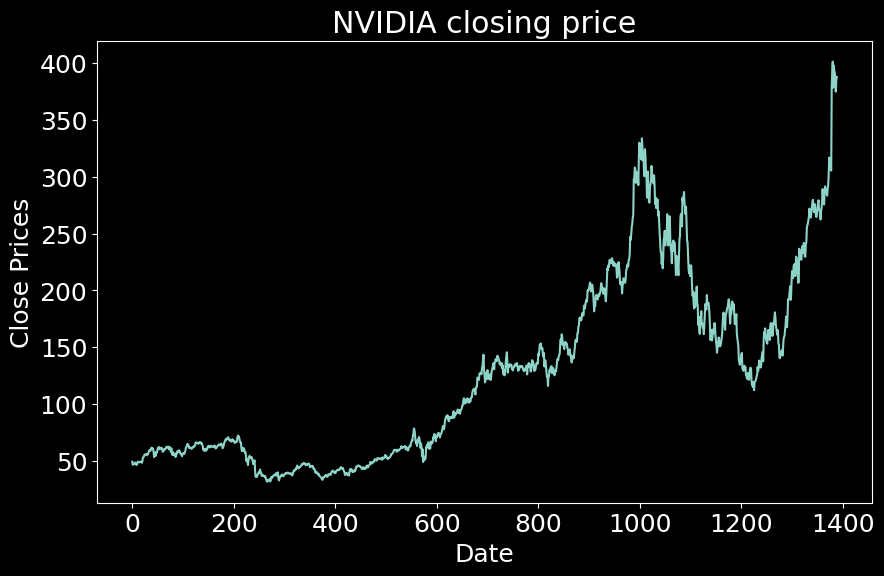

In [36]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_nvda['Close'])
plt.title('NVIDIA closing price')
plt.show()

## Train, test, valid

In [37]:
train_data, test_data, valid_data = train_test_valid(df_nvda)

In [38]:
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)

feature_val_data = augment_features(valid_data)
features_val = extract_features(feature_val_data)

feature_test_data = augment_features(test_data)
features_test = extract_features(feature_test_data)

## Build & Train model

In [39]:
model = GaussianHMM()

### Choose n_component

In [40]:
n_components_values = [4, 6, 8, 10, 12, 14]
num_latent_days = 50
num_days_to_predict = 100

In [41]:
possible_outcomes_test = possibleoutcomes(test_data)

In [42]:
mae_num_components = []
for num_component in n_components_values:
    model = GaussianHMM(n_components=num_component)
    model.fit(features_train)
    predicted_close_prices = []
    for i in tqdm(range(num_days_to_predict)):
        # Calculate start and end indices
        previous_data_start_index = max(0, i - num_latent_days)
        previous_data_end_index = max(0, i)
        # Acquire test data features for these days
        previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

        outcome_scores = []
        for outcome in possible_outcomes_test:
            # Append each outcome one by one with replacement to see which sequence generates the highest score
            total_data = np.row_stack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))

        # Take the most probable outcome as the one with the highest score
        most_probable_outcome = possible_outcomes_test[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    mae_num_components.append((abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)).mean())

100%|██████████| 100/100 [05:00<00:00,  3.00s/it]


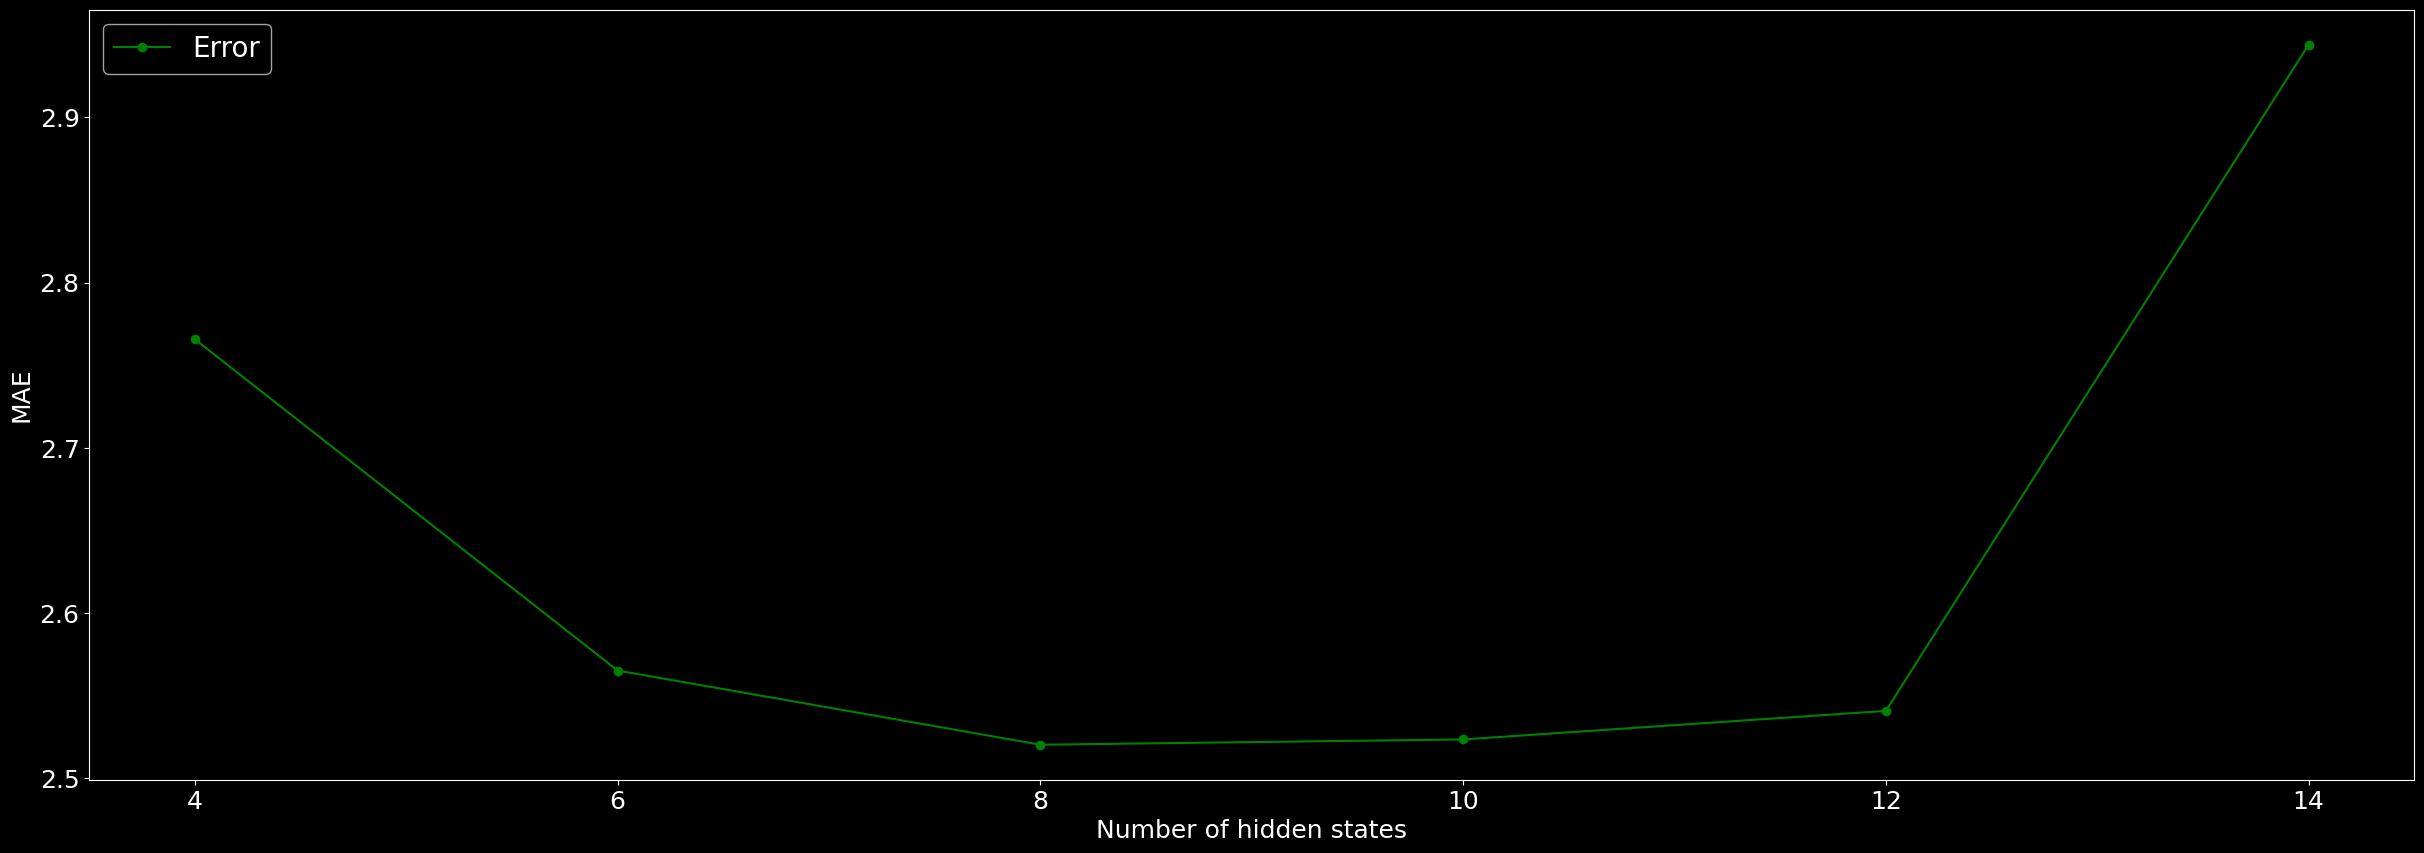

In [43]:
plt.figure(figsize=(30,10))

plt.plot(n_components_values, mae_num_components, 'go-', label="Error")
plt.xlabel("Number of hidden states")
plt.ylabel("MAE")
plt.legend(prop={'size': 20})
plt.show()

### Train

In [44]:
model = GaussianHMM(n_components=8).fit(features_train)

## Eval

In [45]:
predict_test = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

    outcome_scores = []
    for outcome in possible_outcomes_test:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))

    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes_test[np.argmax(outcome_scores)]
    predict_test.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 100/100 [04:05<00:00,  2.45s/it]


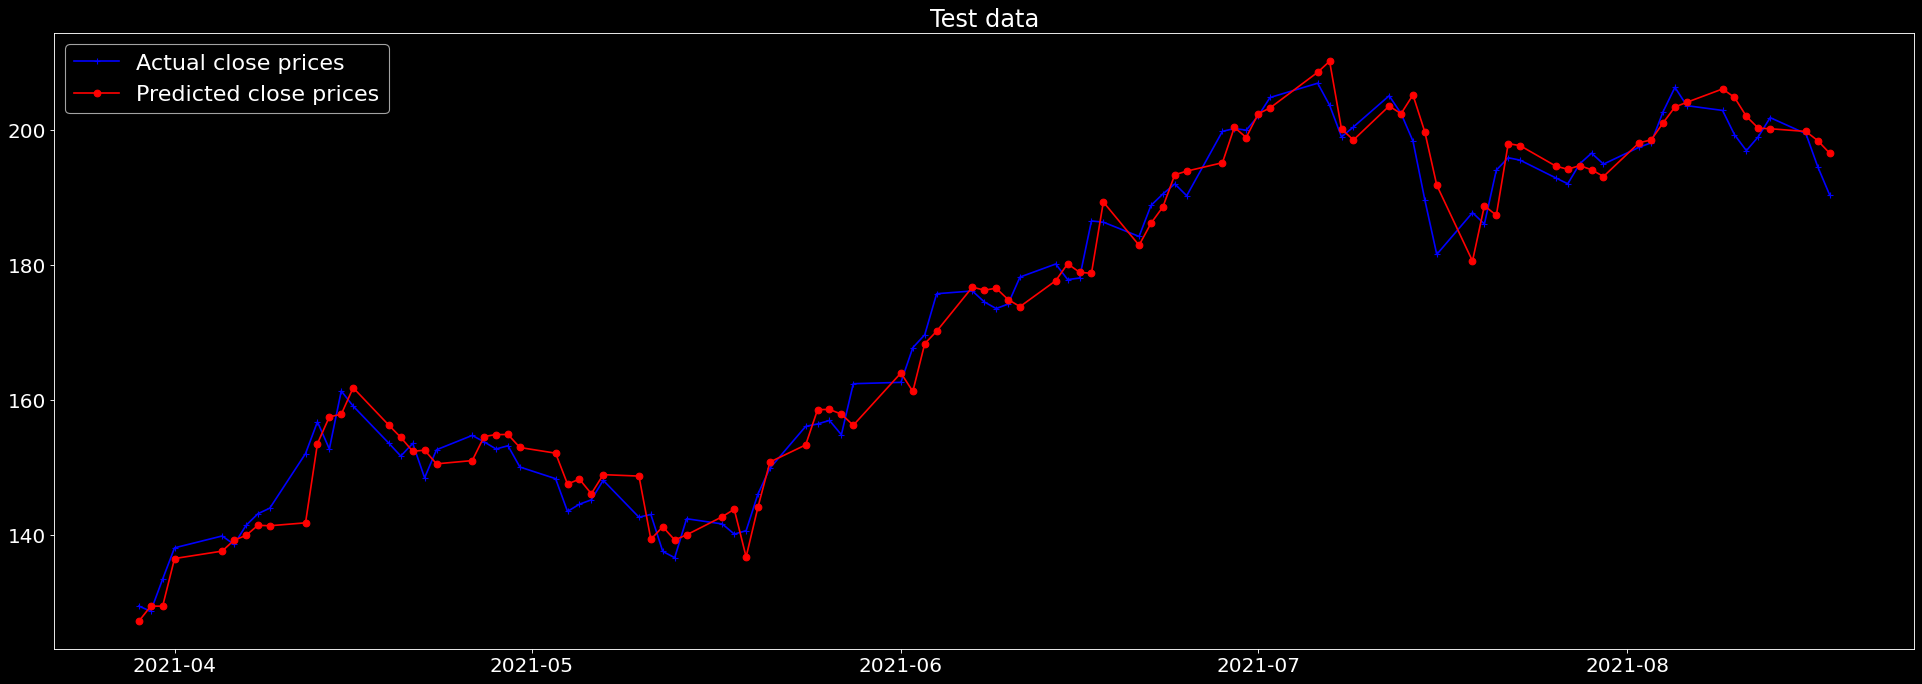

In [46]:
plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(test_data['Date'][0:num_days_to_predict])
plt.plot(x_axis, test_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predict_test, 'ro-', label="Predicted close prices")
plt.title('Test data')
plt.legend(prop={'size': 20})
plt.show()

In [47]:
possible_outcomes_val = possibleoutcomes(valid_data)

predict_val = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(valid_data.iloc[previous_data_start_index:previous_data_end_index]))

    outcome_scores = []
    for outcome in possible_outcomes_val:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))

    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes_val[np.argmax(outcome_scores)]
    predict_val.append(valid_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 100/100 [04:03<00:00,  2.43s/it]


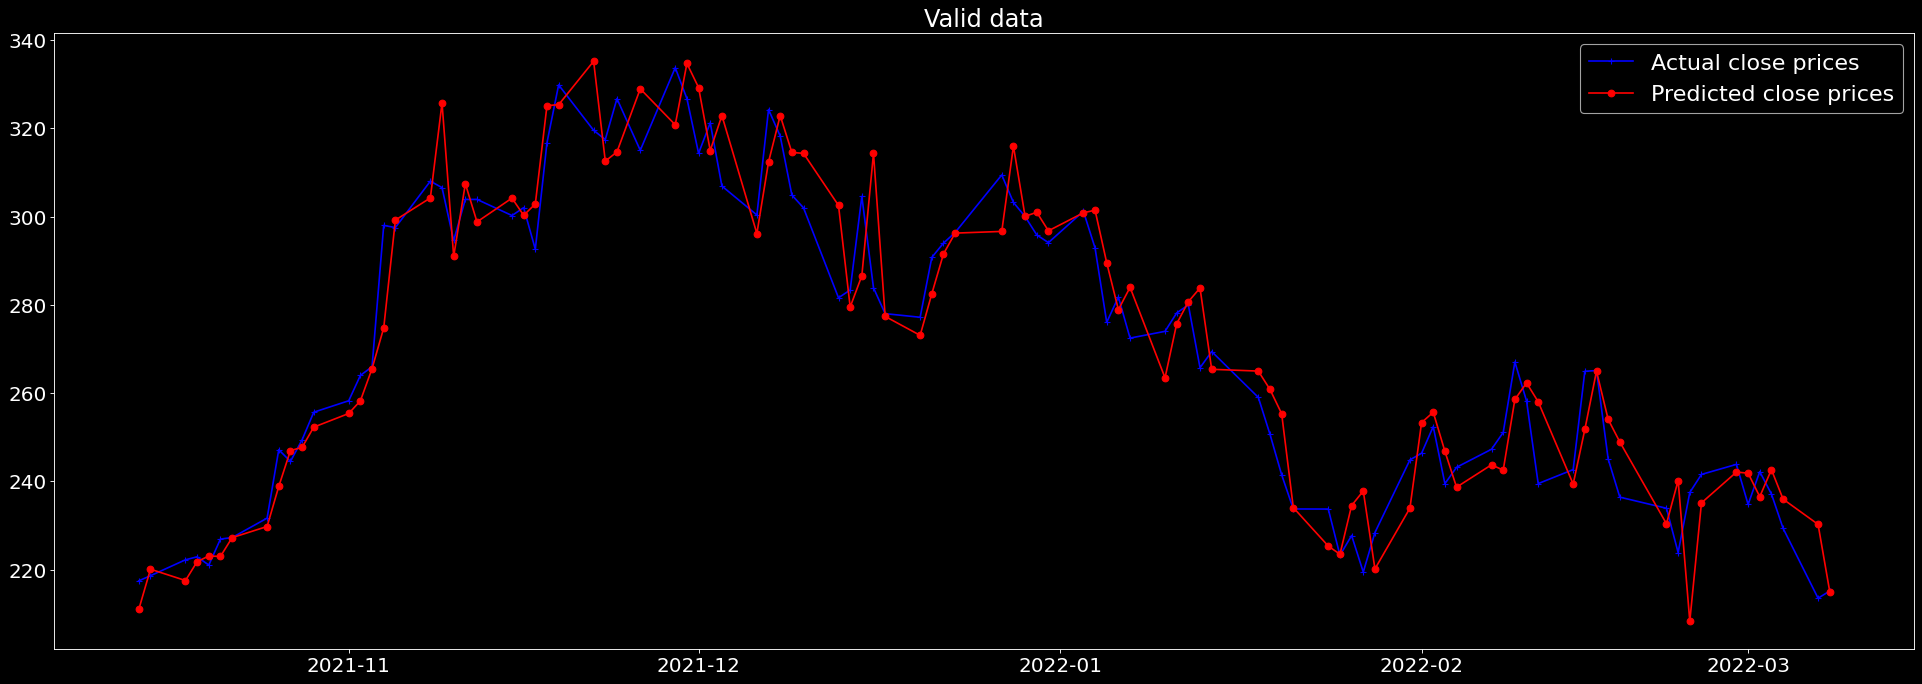

In [48]:
plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(valid_data['Date'][0:num_days_to_predict])
plt.plot(x_axis, valid_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predict_val, 'ro-', label="Predicted close prices")
plt.title('Valid data')
plt.legend(prop={'size': 20})
plt.show()

In [49]:
eval(test_data.iloc[0:num_days_to_predict]['Close'],predict_test,valid_data.iloc[0:num_days_to_predict]['Close'],predict_val)

** Testing **
MAE:  2.8751266291409934
MAPE:  1.7032488165459188
RMSE:  3.6083513739236963

** Validate **
MAE:  7.632878568443821
MAPE:  2.83748936464216
RMSE:  9.933962463947541


# TESLA

## Data

In [50]:
df_tsla = pd.read_csv("TSLA.csv")
df_tsla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,20.362667,20.688000,20.336666,20.435333,20.435333,64393500
1,2017-12-04,20.433332,20.551332,20.040667,20.346666,20.346666,87526500
2,2017-12-05,20.133333,20.533333,20.066668,20.246668,20.246668,69697500
3,2017-12-06,20.006666,20.892668,20.000000,20.884001,20.884001,107929500
4,2017-12-07,20.799999,21.242001,20.736668,20.749332,20.749332,71709000
...,...,...,...,...,...,...,...
1384,2023-06-05,217.800003,221.289993,214.520004,217.610001,217.610001,151143100
1385,2023-06-06,216.139999,221.910004,212.529999,221.309998,221.309998,146911600
1386,2023-06-07,228.000000,230.830002,223.199997,224.570007,224.570007,185710800
1387,2023-06-08,224.220001,235.229996,223.009995,234.860001,234.860001,164489700


## Preprocessing

### Check null and na value

In [51]:
df_tsla.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [52]:
df_tsla.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [53]:
print("Date column data type: ", type(df_tsla['Date'][0]))
print("Open column data type: ", type(df_tsla['Open'][0]))
print("Close column data type: ", type(df_tsla['Close'][0]))
print("High column data type: ", type(df_tsla['High'][0]))
print("Low column data type: ", type(df_tsla['Low'][0]))
print("Adj Close column data type: ", type(df_tsla['Adj Close'][0]))
print("Volume column data type: ", type(df_tsla['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [54]:
df_tsla['Date'] = pd.to_datetime(df_tsla.Date)

## EDA

### Get the duration of dataset

In [55]:
print("Starting date: ",df_tsla.iloc[0][0])
print("Ending date: ", df_tsla.iloc[-1][0])
print("Duration: ", df_tsla.iloc[-1][0]-df_tsla.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

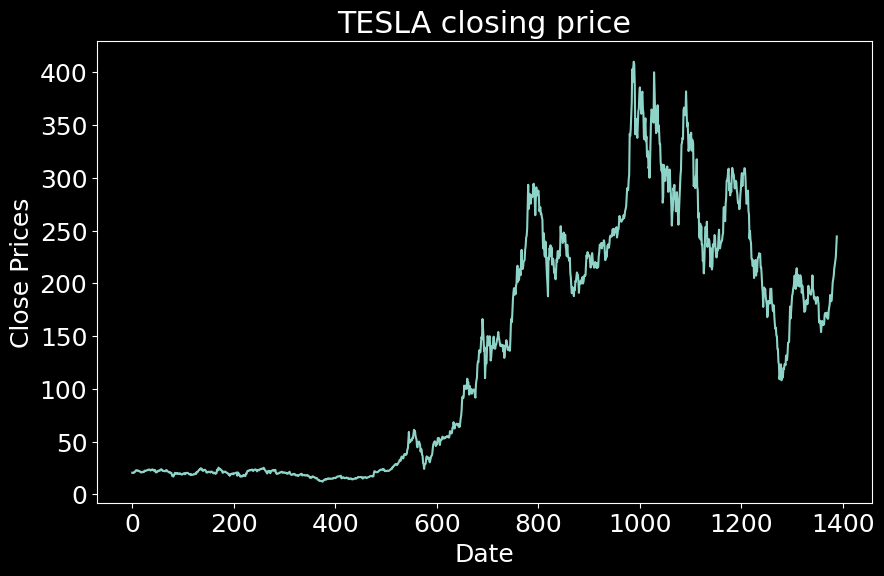

In [56]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_tsla['Close'])
plt.title('TESLA closing price')
plt.show()

## Train, test, valid

In [57]:
train_data, test_data, valid_data = train_test_valid(df_tsla)

In [58]:
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)

feature_val_data = augment_features(valid_data)
features_val = extract_features(feature_val_data)

feature_test_data = augment_features(test_data)
features_test = extract_features(feature_test_data)

## Build & Train model

In [59]:
model = GaussianHMM()

### Choose n_component

In [60]:
n_components_values = [4, 6, 8, 10, 12, 14]
num_latent_days = 50
num_days_to_predict = 100

In [61]:
possible_outcomes_test = possibleoutcomes(test_data)

In [62]:
mae_num_components = []
for num_component in n_components_values:
    model = GaussianHMM(n_components=num_component)
    model.fit(features_train)
    predicted_close_prices = []
    for i in tqdm(range(num_days_to_predict)):
        # Calculate start and end indices
        previous_data_start_index = max(0, i - num_latent_days)
        previous_data_end_index = max(0, i)
        # Acquire test data features for these days
        previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

        outcome_scores = []
        for outcome in possible_outcomes_test:
            # Append each outcome one by one with replacement to see which sequence generates the highest score
            total_data = np.row_stack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))

        # Take the most probable outcome as the one with the highest score
        most_probable_outcome = possible_outcomes_test[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    mae_num_components.append((abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)).mean())

100%|██████████| 100/100 [04:58<00:00,  2.98s/it]


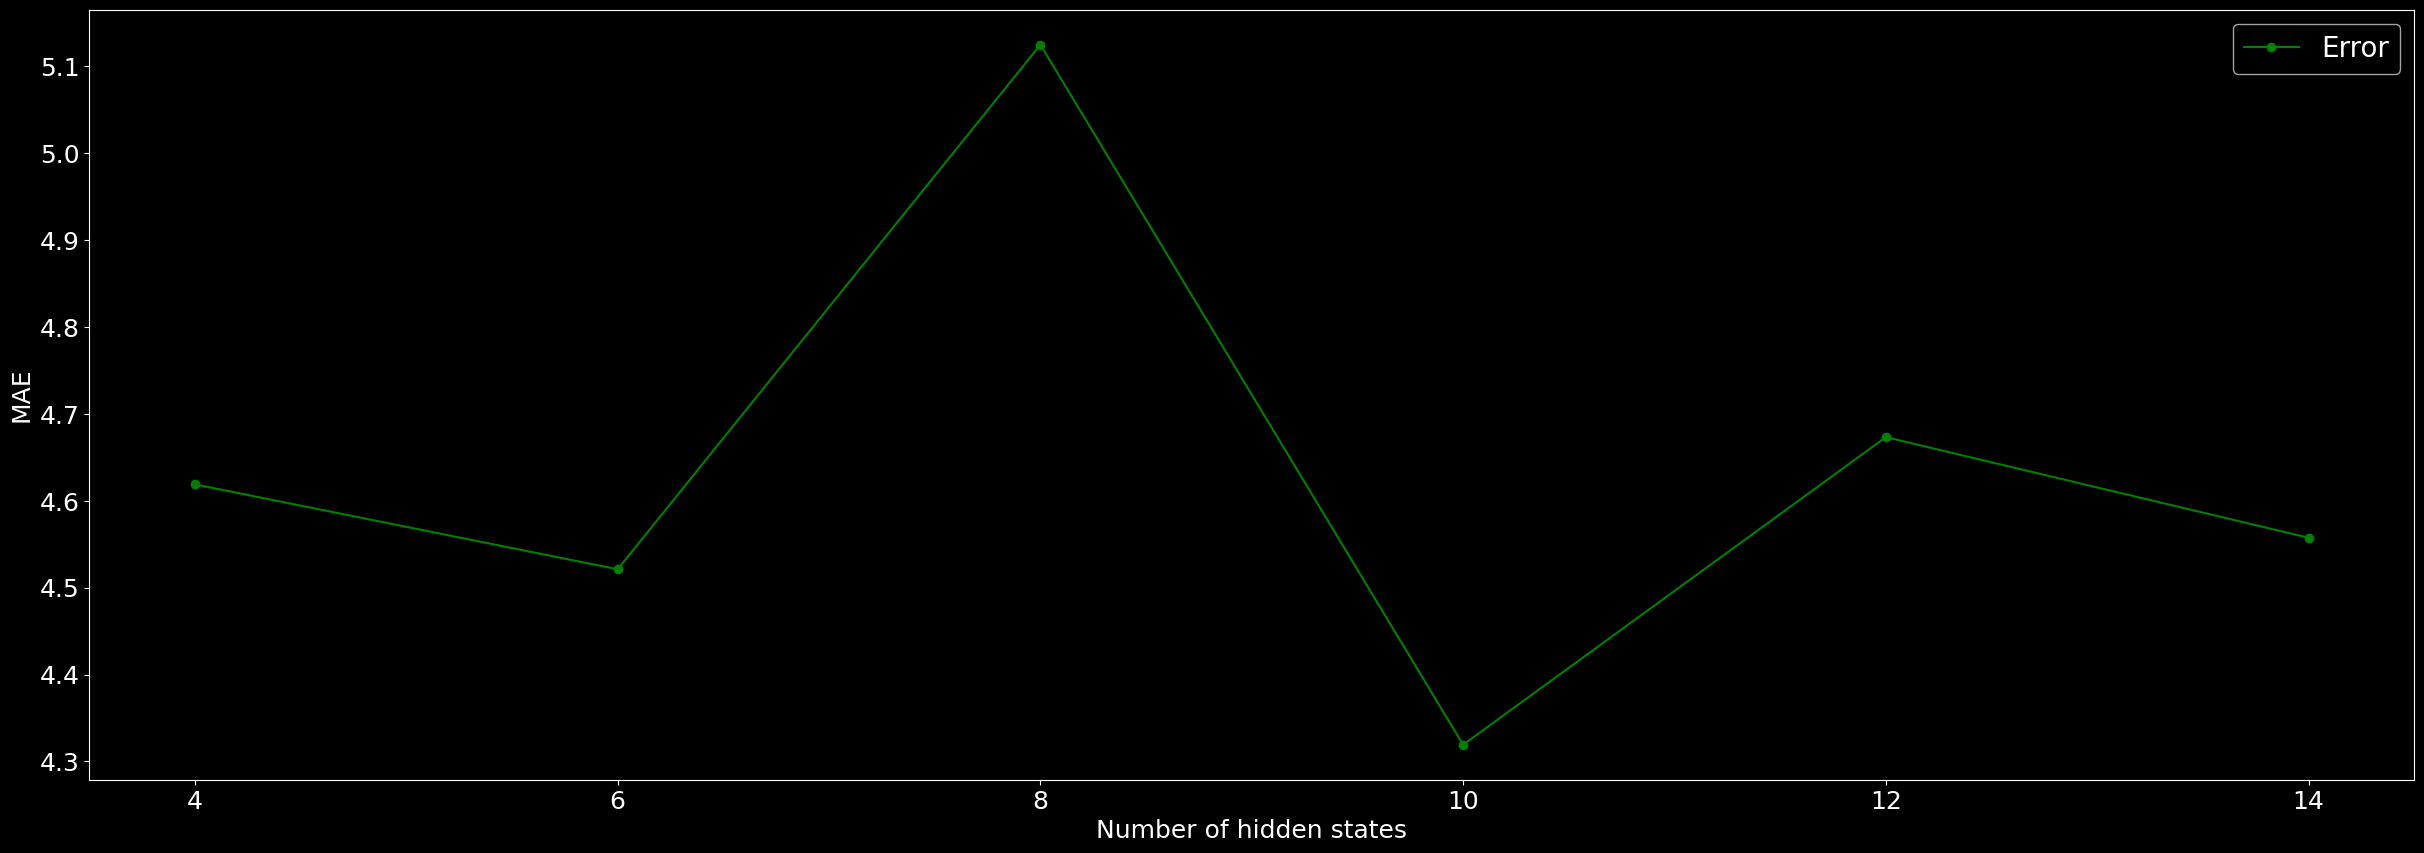

In [63]:
plt.figure(figsize=(30,10))

plt.plot(n_components_values, mae_num_components, 'go-', label="Error")
plt.xlabel("Number of hidden states")
plt.ylabel("MAE")
plt.legend(prop={'size': 20})
plt.show()

### Train

In [64]:
model = GaussianHMM(n_components=10).fit(features_train)

## Eval

In [65]:
predict_test = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

    outcome_scores = []
    for outcome in possible_outcomes_test:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))

    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes_test[np.argmax(outcome_scores)]
    predict_test.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 100/100 [04:22<00:00,  2.63s/it]


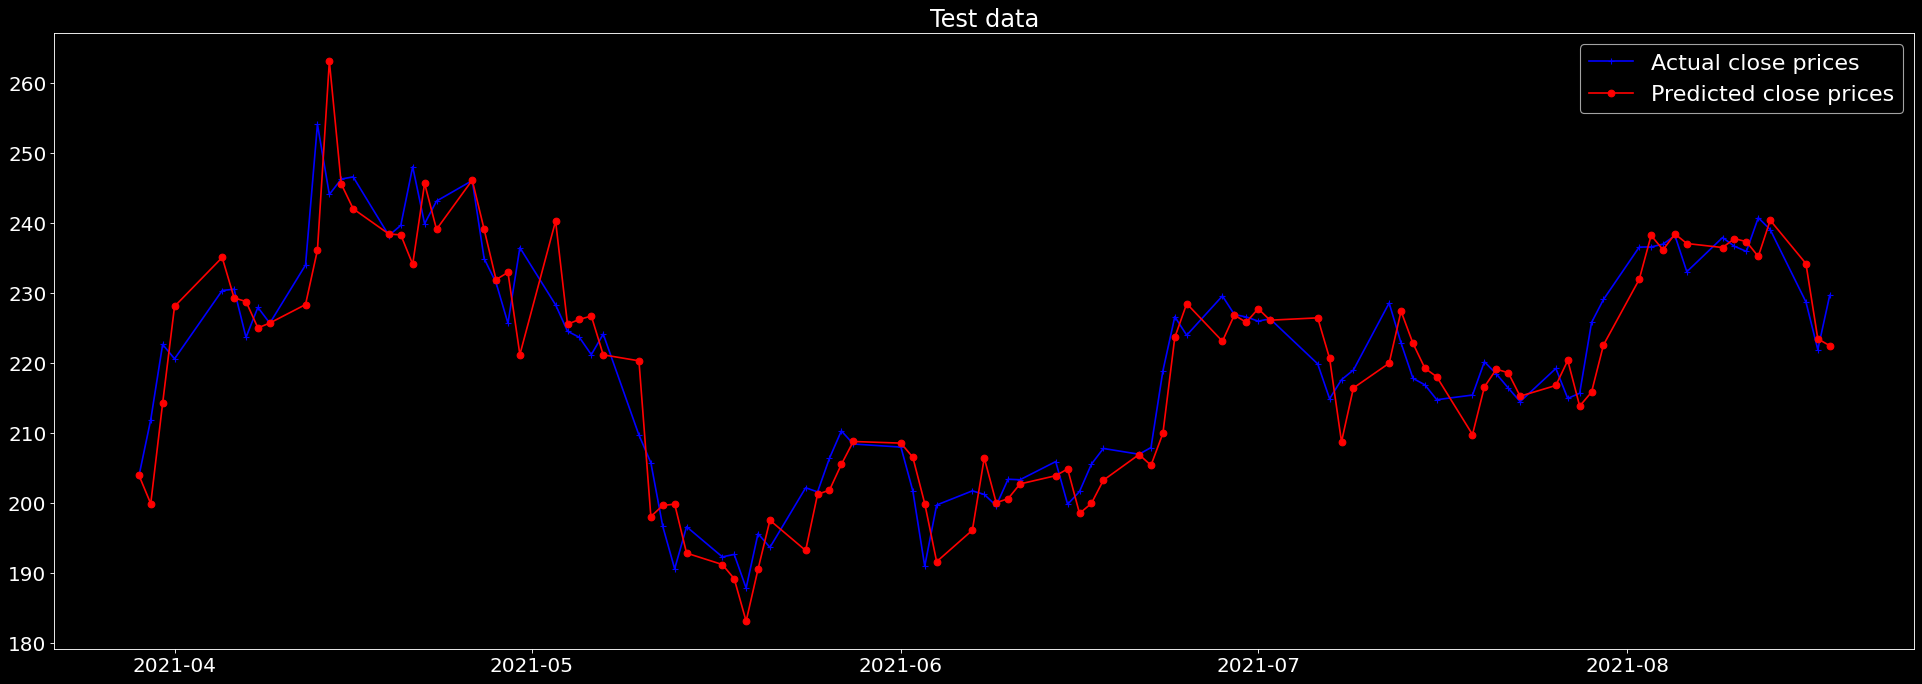

In [66]:
plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(test_data['Date'][0:num_days_to_predict])
plt.plot(x_axis, test_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predict_test, 'ro-', label="Predicted close prices")
plt.title('Test data')
plt.legend(prop={'size': 20})
plt.show()

In [67]:
possible_outcomes_val = possibleoutcomes(valid_data)

predict_val = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(valid_data.iloc[previous_data_start_index:previous_data_end_index]))

    outcome_scores = []
    for outcome in possible_outcomes_val:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))

    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes_val[np.argmax(outcome_scores)]
    predict_val.append(valid_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 100/100 [04:20<00:00,  2.60s/it]


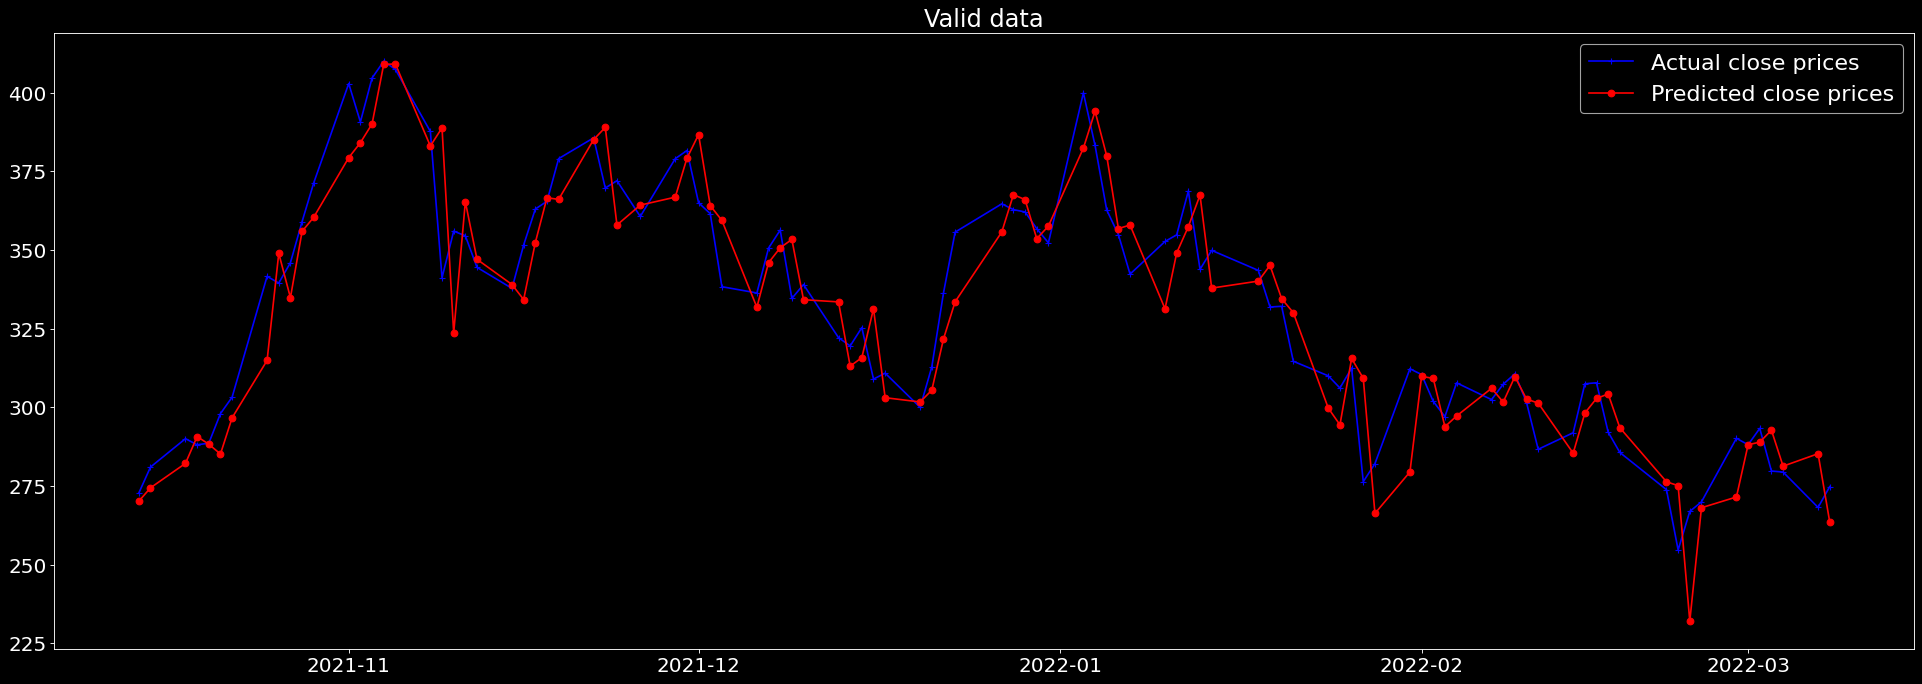

In [68]:
plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(valid_data['Date'][0:num_days_to_predict])
plt.plot(x_axis, valid_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predict_val, 'ro-', label="Predicted close prices")
plt.title('Valid data')
plt.legend(prop={'size': 20})
plt.show()

In [69]:
eval(test_data.iloc[0:num_days_to_predict]['Close'],predict_test,valid_data.iloc[0:num_days_to_predict]['Close'],predict_val)

** Testing **
MAE:  4.469998310455814
MAPE:  2.033186473161623
RMSE:  5.8916729618627315

** Validate **
MAE:  10.472720672843716
MAPE:  3.209913450772696
RMSE:  13.73576978408645
